In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("/home/abishai/Documents/ANN_Research/bio/WaterCycle/wine.csv")

df.head()

,output,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)
df2.head()
df = df2

In [4]:
input_cols = list(df.columns)[1:]
input_cols

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [5]:
output_cols = [0]
output_cols

[0]

In [6]:
df[0].describe()

count    178.000000
mean       0.469101
std        0.387517
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: 0, dtype: float64

In [7]:
def dataframe_to_arrays(df):
    # Make a copy of the original dataframe
    df1 = df.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = df1[input_cols].to_numpy()
    targets_array = df1[output_cols].to_numpy()
    return inputs_array, targets_array

In [8]:
inputs_array, targets_array = dataframe_to_arrays(df)
inputs_array, targets_array

(array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
         0.56134094],
        [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
         0.55064194],
        [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
         0.64693295],
        ...,
        [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
         0.39728959],
        [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
         0.40085592],
        [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
         0.20114123]]),
 array([[0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
        [0. ],
    

In [9]:
import torch
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

In [10]:
from torch.utils.data import DataLoader, TensorDataset, random_split
dataset = TensorDataset(inputs, targets)

In [11]:
num_rows = len(df)
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_df, val_df = random_split(dataset, [train_size, val_size]) 

In [12]:
batch_size = 50

In [13]:
train_loader = DataLoader(train_df, batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size)

In [14]:
input_size = len(input_cols)
output_size = 1
print(input_size)
print(output_size)

13
1


In [15]:
import torch.nn as nn
import torch.nn.functional as F
class WineModel(nn.Module):
    def __init__(self):
        super().__init__()     
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10,output_size)
        # fill this (hint: use input_size & output_size defined above)
        #model initialized with random weight

    def forward(self, xb):
        xb = F.relu(self.fc1(xb))
        out = self.fc2(xb)             # batch wise forwarding
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)         
        # Calcuate loss
        loss = F.l1_loss(out, targets)  # batch wise training step and loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss =F.l1_loss(out, targets)       # batch wise validation and loss    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine val losses of all batches as average
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 500 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [16]:
def evaluate2(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    lr,
    model,
    train_loader,
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate2(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)  #appends total validation loss of whole validation set epoch wise
    return history

In [17]:
model =  WineModel()
result = evaluate2(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 0.8849727511405945}


In [18]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0) 
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [19]:
input, target = val_df[0]
predict_single(input, target, model)

Input: tensor([0.6211, 0.2036, 0.6738, 0.2835, 0.2500, 0.6448, 0.5485, 0.3962, 0.3281,
        0.3003, 0.3577, 0.7143, 0.6541])
Target: tensor([0.])
Prediction: tensor([-0.3783])


In [20]:
epochs = 9000
lr = 1e-2
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [500], val_loss: 0.1126
Epoch [1000], val_loss: 0.0912
Epoch [1500], val_loss: 0.0875
Epoch [2000], val_loss: 0.0866
Epoch [2500], val_loss: 0.0814
Epoch [3000], val_loss: 0.0768
Epoch [3500], val_loss: 0.0703
Epoch [4000], val_loss: 0.0619
Epoch [4500], val_loss: 0.0556
Epoch [5000], val_loss: 0.0591
Epoch [5500], val_loss: 0.0603
Epoch [6000], val_loss: 0.0580
Epoch [6500], val_loss: 0.0710
Epoch [7000], val_loss: 0.0672
Epoch [7500], val_loss: 0.0701
Epoch [8000], val_loss: 0.0603
Epoch [8500], val_loss: 0.0637
Epoch [9000], val_loss: 0.0693


In [21]:
input, target = val_df[1]
predict_single(input, target, model)

Input: tensor([0.4395, 0.5553, 0.5348, 0.5619, 0.3913, 0.2483, 0.1814, 0.0755, 0.1356,
        0.3174, 0.2439, 0.0073, 0.2297])
Target: tensor([1.])
Prediction: tensor([0.8687])


In [22]:
def predict_right(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)#???                # fill this
    prediction = predictions[0].detach()
    if abs(prediction - target) < 0.25:
        return 1
    else:
        return 0

In [23]:
results = []
for i in range(0,len(val_df)):
    input, target = val_df[i]
    results.append(predict_right(input, target, model))

In [24]:
count = 0
for i in results:
    if i == 1:
        count+=1

In [25]:
results

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [26]:
count

17

In [27]:
len(val_df)

17

In [28]:
count/len(val_df)#accuracy

1.0

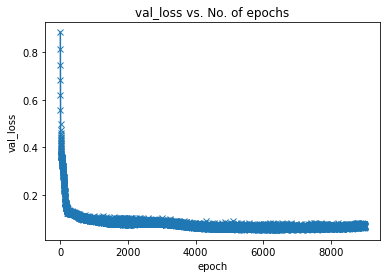

In [29]:
plt.title('val_loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in [result] + history5]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')

val_loss = loss_mat[-1]